# LSTM-arithmetic

## Dataset
- [Arithmetic dataset](https://drive.google.com/file/d/1cMuL3hF9jefka9RyF4gEBIGGeFGZYHE-/view?usp=sharing)

In [ ]:
# ! pip install seaborn
# ! pip install opencc
# ! pip install -U scikit-learn

import numpy as np
import pandas as pd
import torch
import torch.nn
import torch.nn.utils.rnn
import torch.utils.data
import matplotlib.pyplot as plt
import seaborn as sns
import opencc
import os
from sklearn.model_selection import train_test_split

data_path = './data'

In [2]:
df_train = pd.read_csv(os.path.join(data_path, 'arithmetic_train.csv'))
df_eval = pd.read_csv(os.path.join(data_path, 'arithmetic_eval.csv'))
df_train.head()

,src,tgt
0,14*(43+20)=,882
1,(6+1)*5=,35
2,13+32+29=,74
3,31*(3-11)=,-248
4,24*49+1=,1177


In [3]:
# transform the input data to string
df_train['tgt'] = df_train['tgt'].apply(lambda x: str(x))
df_train['src'] = df_train['src'].add(df_train['tgt'])
df_train['len'] = df_train['src'].apply(lambda x: len(x))
df_train

,src,tgt,len
0,14*(43+20)=882,882,14
1,(6+1)*5=35,35,10
2,13+32+29=74,74,11
3,31*(3-11)=-248,-248,14
4,24*49+1=1177,1177,12
...,...,...,...
2369245,1+(37*8)=297,297,12
2369246,37-25-19=-7,-7,11
2369247,7+39-40=6,6,9
2369248,27-28-12=-13,-13,12


In [4]:
df_eval['tgt'] = df_eval['tgt'].apply(lambda x: str(x))
df_eval['len'] = df_eval['src'].apply(lambda x: len(x))
df_eval

,src,tgt,len
0,48+43+34=,125,9
1,30-(48+13)=,-31,11
2,(21*31)+10=,661,11
3,2-27-10=,-35,8
4,(15*20)+24=,324,11
...,...,...,...
263245,14*43*23=,13846,9
263246,48-(5*27)=,-87,10
263247,30*42+16=,1276,9
263248,21*(10-15)=,-105,11


# Build Dictionary
 - The model cannot perform calculations directly with plain text.
 - Convert all text (numbers/symbols) into numerical representations.
 - Special tokens
    - '&lt;pad&gt;'
        - Each sentence within a batch may have different lengths.
        - The length is padded with '&lt;pad&gt;' to match the longest sentence in the batch.
    - '&lt;eos&gt;'
        - Specifies the end of the generated sequence.
        - Without '&lt;eos&gt;', the model will not know when to stop generating.

In [5]:
char_to_id = {}
id_to_char = {}

# write your code here
# Build a dictionary and give every token in the train dataset an id
# The dictionary should contain <eos> and <pad>
# char_to_id is to conver charactors to ids, while id_to_char is the opposite
char_to_id = {}
id_to_char = {}
chars = set()

for row in df_train.itertuples(index=True, name='Row'):
    for char in row.tgt:
        if char not in chars:
            chars.update(char)
    for char in row.src:
        if char not in chars:
            chars.update(char)

for row in df_eval.itertuples(index=True, name='Row'):
    for char in row.tgt:
        if char not in chars:
            chars.update(char)
    for char in row.src:
        if char not in chars:
            chars.update(char)
    
len(chars)

char_to_id = {'<pad>': 0, '<eos>': 1}
id_to_char = {0: '<pad>', 1: '<eos>'}

cur_idx = 2

for char in chars:
    char_to_id[char] = cur_idx
    id_to_char[cur_idx] = char
    cur_idx += 1

vocab_size = len(char_to_id)
print('Vocab size: {}'.format(vocab_size))

Vocab size: 18


In [6]:
char_to_id

{'<pad>': 0,
 '<eos>': 1,
 '+': 2,
 '(': 3,
 '8': 4,
 '2': 5,
 '0': 6,
 '3': 7,
 '1': 8,
 '9': 9,
 '6': 10,
 '7': 11,
 '=': 12,
 '5': 13,
 '*': 14,
 ')': 15,
 '4': 16,
 '-': 17}

In [7]:
id_to_char

{0: '<pad>',
 1: '<eos>',
 2: '+',
 3: '(',
 4: '8',
 5: '2',
 6: '0',
 7: '3',
 8: '1',
 9: '9',
 10: '6',
 11: '7',
 12: '=',
 13: '5',
 14: '*',
 15: ')',
 16: '4',
 17: '-'}

# Data Preprocessing
 - The data is processed into the format required for the model's input and output. (End with \<eos\> token)


In [8]:
from tqdm import tqdm
tqdm.pandas()
# Write your code here
df_train["char_id_list"] = None
df_train["label_id_list"] = None

def create_char_id_list(src_str, char_to_id):
    char_ids = []
    for char in src_str:
        char_ids.append(char_to_id[char])
    char_ids.append(char_to_id["<eos>"])
    return char_ids

def create_label_id_list(row, char_to_id):
    label_ids = []

    for char in row.tgt:
        label_ids.append(char_to_id[char])
    label_ids.append(char_to_id["<eos>"])

    dif_length = row.len - len(str(row.tgt))

    for _ in range(dif_length):
        label_ids.insert(0, char_to_id["<pad>"])

    return label_ids

# I used gemini due to inefficient for loop logic before, it suggested to me the use of the "apply" format for internal pandas processing
# The rest of the logic I implemented it with basic list and dictionary manipulation, so I just converted the logic to functions to work with "apply"
# In this case is "progress_apply" because I wanted to observe the progress with tqdm
df_train["char_id_list"] = df_train["src"].progress_apply(lambda x: create_char_id_list(x, char_to_id))

df_train["label_id_list"] = df_train.progress_apply(lambda row: create_label_id_list(row, char_to_id), axis=1)

df_train.head()

  0%|          | 0/2369250 [00:00<?, ?it/s]

100%|██████████| 2369250/2369250 [00:28<00:00, 84607.52it/s]


,src,tgt,len,char_id_list,label_id_list
0,14*(43+20)=882,882,14,"[8, 16, 14, 3, 16, 7, 2, 5, 6, 15, 12, 4, 4, 5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 5, 1]"
1,(6+1)*5=35,35,10,"[3, 10, 2, 8, 15, 14, 13, 12, 7, 13, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 7, 13, 1]"
2,13+32+29=74,74,11,"[8, 7, 2, 7, 5, 2, 5, 9, 12, 11, 16, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 16, 1]"
3,31*(3-11)=-248,-248,14,"[7, 8, 14, 3, 7, 17, 8, 8, 15, 12, 17, 5, 16, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 5, 16, 4, 1]"
4,24*49+1=1177,1177,12,"[5, 16, 14, 16, 9, 2, 8, 12, 8, 8, 11, 11, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 11, 11, 1]"


In [9]:
from tqdm import tqdm
tqdm.pandas()

df_eval["char_id_list"] = None
df_eval["label_id_list"] = None

def create_char_id_list(src_str, char_to_id):
    char_ids = []
    for char in src_str:
        char_ids.append(char_to_id[char])
    char_ids.append(char_to_id["<eos>"])
    return char_ids

def create_label_id_list(row, char_to_id):
    label_ids = []

    for char in row.tgt:
        label_ids.append(char_to_id[char])
    label_ids.append(char_to_id["<eos>"])

    dif_length = row.len - len(str(row.tgt))

    for _ in range(dif_length):
        label_ids.insert(0, char_to_id["<pad>"])

    return label_ids

# I used gemini due to inefficient for loop logic before, it suggested to me the use of the "apply" format for internal pandas processing
# The rest of the logic I implemented it with basic list and dictionary manipulation, so I just converted the logic to functions to work with "apply"
# In this case is "progress_apply" because I wanted to observe the progress with tqdm
df_eval["char_id_list"] = df_eval["src"].progress_apply(lambda x: create_char_id_list(x, char_to_id))

df_eval["label_id_list"] = df_eval.progress_apply(lambda row: create_label_id_list(row, char_to_id), axis=1)

df_eval.head()

100%|██████████| 263250/263250 [00:02<00:00, 91797.18it/s]


,src,tgt,len,char_id_list,label_id_list
0,48+43+34=,125,9,"[16, 4, 2, 16, 7, 2, 7, 16, 12, 1]","[0, 0, 0, 0, 0, 0, 8, 5, 13, 1]"
1,30-(48+13)=,-31,11,"[7, 6, 17, 3, 16, 4, 2, 8, 7, 15, 12, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 17, 7, 8, 1]"
2,(21*31)+10=,661,11,"[3, 5, 8, 14, 7, 8, 15, 2, 8, 6, 12, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 8, 1]"
3,2-27-10=,-35,8,"[5, 17, 5, 11, 17, 8, 6, 12, 1]","[0, 0, 0, 0, 0, 17, 7, 13, 1]"
4,(15*20)+24=,324,11,"[3, 8, 13, 14, 5, 6, 15, 2, 5, 16, 12, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 7, 5, 16, 1]"


# Hyper Parameters

|Hyperparameter|Meaning|Value|
|-|-|-|
|`batch_size`|Number of data samples in a single batch|64|
|`epochs`|Total number of epochs to train|10|
|`embed_dim`|Dimension of the word embeddings|256|
|`hidden_dim`|Dimension of the hidden state in each timestep of the LSTM|256|
|`lr`|Learning Rate|0.001|
|`grad_clip`|To prevent gradient explosion in RNNs, restrict the gradient range|1|

In [10]:
batch_size = 64
epochs = 2
embed_dim = 256
hidden_dim = 256
lr = 0.001
grad_clip = 1

# Data Batching
- Use `torch.utils.data.Dataset` to create a data generation tool called  `dataset`.
- The, use `torch.utils.data.DataLoader` to randomly sample from the `dataset` and group the samples into batches.

- Example: 1+2-3=0
    - Model input: 1 + 2 - 3 = 0
    - Model output: / / / / / 0 &lt;eos&gt;  (the '/' can be replaced with &lt;pad&gt;)
    - The key for the model's output is that the model does not need to predict the next character of the previous part. What matters is that once the model sees '=', it should start generating the answer, which is '0'. After generating the answer, it should also generate&lt;eos&gt;

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        # return the amount of data
        return len(self.sequences) # Write your code here
    
    def __getitem__(self, index):
        # Extract the input data x and the ground truth y from the data
        x = self.sequences.iloc[index]["char_id_list"] # Write your code here
        y = self.sequences.iloc[index]["label_id_list"] # Write your code here
        return x, y

# collate function, used to build dataloader
def collate_fn(batch):
    batch_x = [torch.tensor(data[0]) for data in batch]
    batch_y = [torch.tensor(data[1]) for data in batch]
    batch_x_lens = torch.LongTensor([len(x) for x in batch_x])
    batch_y_lens = torch.LongTensor([len(y) for y in batch_y])
    
    # Pad the input sequence
    pad_batch_x = torch.nn.utils.rnn.pad_sequence(batch_x,
                                                  batch_first=True,
                                                  padding_value=char_to_id['<pad>'])
    
    pad_batch_y = torch.nn.utils.rnn.pad_sequence(batch_y,
                                                  batch_first=True,
                                                  padding_value=char_to_id['<pad>'])
    
    return pad_batch_x, pad_batch_y, batch_x_lens, batch_y_lens

In [12]:
ds_train = Dataset(df_train[['char_id_list', 'label_id_list']])

In [13]:
# Build dataloader of train set and eval set, collate_fn is the collate function
dl_train = torch.utils.data.DataLoader(dataset=ds_train, collate_fn=collate_fn, batch_size=batch_size, shuffle=True, num_workers=32)# Write your code here

In [14]:
ds_eval = Dataset(df_eval[['char_id_list', 'label_id_list']])
dl_eval = torch.utils.data.DataLoader(dataset=ds_eval, collate_fn=collate_fn, batch_size=batch_size, shuffle=False, num_workers=32)# Write your code here

# Model Design

## Execution Flow
1. Convert all characters in the sentence into embeddings.
2. Pass the embeddings through an LSTM sequentially.
3. The output of the LSTM is passed into another LSTM, and additional layers can be added.
4. The output from all time steps of the final LSTM is passed through a Fully Connected layer.
5. The character corresponding to the maximum value across all output dimensions is selected as the next character.

## Loss Function
Since this is a classification task, Cross Entropy is used as the loss function.

## Gradient Update
Adam algorithm is used for gradient updates.

In [15]:
class CharRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(CharRNN, self).__init__()
        
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size,
                                            embedding_dim=embed_dim,
                                            padding_idx=char_to_id['<pad>'])
        
        self.rnn_layer1 = torch.nn.LSTM(input_size=embed_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.rnn_layer2 = torch.nn.LSTM(input_size=hidden_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True)
        
        self.linear = torch.nn.Sequential(torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(in_features=hidden_dim,
                                                          out_features=vocab_size))
        
    def forward(self, batch_x, batch_x_lens):
        return self.encoder(batch_x, batch_x_lens)
    
    # The forward pass of the model
    def encoder(self, batch_x, batch_x_lens):
        batch_x = self.embedding(batch_x)
        
        batch_x = torch.nn.utils.rnn.pack_padded_sequence(batch_x,
                                                          batch_x_lens,
                                                          batch_first=True,
                                                          enforce_sorted=False)
        
        batch_x, _ = self.rnn_layer1(batch_x)
        batch_x, _ = self.rnn_layer2(batch_x)
        
        batch_x, _ = torch.nn.utils.rnn.pad_packed_sequence(batch_x,
                                                            batch_first=True)
        
        batch_x = self.linear(batch_x)
        
        return batch_x
    
    def generator(self, start_char, max_len=200):
        
        char_list = [char_to_id[c] for c in start_char]
        
        next_char = None
        
        while len(char_list) < max_len: 
            # Write your code here 
            # Pack the char_list to tensor
            device = self.embedding.weight.device
            input_tensor = torch.tensor(char_list).unsqueeze(0).to(device)
            
            # Input the tensor to the embedding layer, LSTM layers, linear respectively
            embedding_input = self.embedding(input_tensor)
            embedding_input, _ = self.rnn_layer1(embedding_input)
            embedding_input, _ = self.rnn_layer2(embedding_input) 
            y = self.linear(embedding_input)# Obtain the next token prediction y
            last_char_logits = y[:, -1, :]
            next_char = torch.argmax(last_char_logits, dim=1).item() # Use argmax function to get the next token prediction
            
            if next_char == char_to_id['<eos>']:
                break
            
            char_list.append(next_char)
            
        return [id_to_char[ch_id] for ch_id in char_list]

In [16]:
torch.manual_seed(2)


device = torch.device("cuda") # Write your code here. Specify a device (cuda or cpu)

model = CharRNN(vocab_size,
                embed_dim,
                hidden_dim)

In [17]:
criterion = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=char_to_id['<pad>']) # Write your code here. Cross-entropy loss function. The loss function should ignore <pad>
optimizer = torch.optim.Adam(model.parameters(), lr = lr)# Write your code here. Use Adam or AdamW for Optimizer

# Training
1. The outer `for` loop controls the `epoch`
    1. The inner `for` loop uses `data_loader` to retrieve batches.
        1. Pass the batch to the `model` for training.
        2. Compare the predicted results `batch_pred_y` with the true labels `batch_y` using Cross Entropy to calculate the loss `loss`
        3. Use `loss.backward` to automatically compute the gradients.
        4. Use `torch.nn.utils.clip_grad_value_` to limit the gradient values between `-grad_clip` &lt; and &lt; `grad_clip`.
        5. Use `optimizer.step()` to update the model (backpropagation).
2.  After every `1000` batches, output the current loss to monitor whether it is converging.

In [ ]:
# In here I needed some help from Gemini to see how to make the mask to not pass over the characters before '=' to the loss function
# Also to make my data be in the correct tensor dimension
from tqdm import tqdm
from copy import deepcopy
model = model.to(device)

i = 0
for epoch in range(1, epochs+1):
    # The process bar
    bar = tqdm(dl_train, desc=f"Train epoch {epoch}")
    for batch_x, batch_y, batch_x_lens, batch_y_lens in bar:
        # Write your code here
        model.train()
        # Clear the gradient
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        batch_pred_y = model(batch_x, batch_x_lens)
        
        # Write your code here
        # Input the prediction and ground truths to loss function

        labels_reshaped = batch_y[:, 1:].contiguous().view(-1)
        predictions_reshaped = batch_pred_y[:, :-1, :].contiguous().view(-1, vocab_size).to(device)

        # Create mask
        equal_token_id = char_to_id['=']
        mask = torch.zeros_like(batch_y, dtype=torch.bool, device=device)
        for b in range(batch_y.size(0)):
            eq_positions = (batch_x[b] == equal_token_id).nonzero(as_tuple=True)[0]
            if len(eq_positions) > 0:
                eq_idx = eq_positions[0].item()
                # the model predicts from eq_idx+1 onward
                mask[b, eq_idx + 1 : batch_y_lens[b]] = True

        # compute loss on mask
        mask = mask[:, 1:]  

        # criterion = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=char_to_id['<pad>'])
        loss_all = criterion(predictions_reshaped, labels_reshaped)
        loss_all = loss_all.view(mask.size())  

        # Apply mask
        masked_loss = loss_all * mask.float()
        loss = masked_loss.sum() / mask.sum()

        # Back propagation
        loss.backward()
        

        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip) # gradient clipping

        # Write your code here
        # Optimize parameters in the model
        optimizer.step()
        
        i+=1
        if i%50==0:
            bar.set_postfix(loss = loss.item())
        
        # Prints loss every 1000 batches
        # if i%1000==0:
        #     print(f"loss: {loss.item()}")
        
    
    # Evaluate your model
    matched = 0
    total = 0
    count = 0
    # model.eval()
    with torch.no_grad():
        bar_eval = tqdm(dl_eval, desc=f"Validation epoch {epoch}")
        for batch_x, batch_y, batch_x_lens, batch_y_lens in bar_eval:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            for b in range(batch_x.size(0)):
                total+=1
                
                # An example of using generator: model.generator('1+1=')
                
                # Write your code here. Input the batch_x to the model and generate the predictions
                input_chars = [id_to_char[idx.item()] for idx in batch_x[b] if idx.item() != char_to_id['<pad>']]
                input_str = "".join(input_chars).replace("<eos>", "")
                # print(input_str)
                prediction = model.generator(input_str)
                prediction_str = "".join(prediction)
                        
                if '=' in prediction_str:
                    predicted_answer = prediction_str.split('=')[1].strip()
                else:
                    predicted_answer = prediction_str.strip()

                # prediction_reshaped = prediction.view(-1, vocab_size)
                # label_reshaped = batch_y.to(device).view(-1)
                
                # Write your code here.
                # Check whether the prediction match the ground truths
                # Compute exact match (EM) on the eval dataset
                # EM = correct/total

                target_chars = [id_to_char[idx.item()] for idx in batch_y[b] if idx.item() not in [char_to_id['<pad>'], char_to_id['<eos>']]]
                target_str = "".join(target_chars).strip()

                if predicted_answer==target_str:
                    matched+=1

                if count<5:
                    print(f"prediction: {predicted_answer}")
                    print(f"batch_y: {target_str}")
                    count+=1

        print(f"EM Accuracy: {matched/total}")

Train epoch 1:   3%|▎         | 1011/37020 [00:13<05:52, 102.04it/s, loss=1.15]

loss: 1.1489059925079346


Train epoch 1:   5%|▌         | 2010/37020 [00:23<05:49, 100.04it/s, loss=0.897]

loss: 0.8969962000846863


Train epoch 1:   8%|▊         | 3015/37020 [00:35<06:44, 84.07it/s, loss=0.715] 

loss: 0.7151417136192322


Train epoch 1:  11%|█         | 4016/37020 [00:46<06:24, 85.83it/s, loss=0.645] 

loss: 0.6447811126708984


Train epoch 1:  14%|█▎        | 5009/37020 [00:58<06:08, 86.90it/s, loss=0.721]

loss: 0.7212268710136414


Train epoch 1:  16%|█▋        | 6017/37020 [01:09<05:53, 87.77it/s, loss=0.662]

loss: 0.6620133519172668


Train epoch 1:  19%|█▉        | 7016/37020 [01:20<05:41, 87.90it/s, loss=0.603]

loss: 0.6026744842529297


Train epoch 1:  22%|██▏       | 8015/37020 [01:32<05:29, 88.05it/s, loss=0.575]

loss: 0.5753727555274963


Train epoch 1:  24%|██▍       | 9018/37020 [01:43<04:36, 101.37it/s, loss=0.499]

loss: 0.4989047944545746


Train epoch 1:  27%|██▋       | 10019/37020 [01:52<04:25, 101.64it/s, loss=0.58]

loss: 0.5799318552017212


Train epoch 1:  30%|██▉       | 11010/37020 [02:03<05:04, 85.44it/s, loss=0.497] 

loss: 0.4965682923793793


Train epoch 1:  32%|███▏      | 12012/37020 [02:15<04:44, 87.83it/s, loss=0.512]

loss: 0.5123268961906433


Train epoch 1:  35%|███▌      | 13008/37020 [02:26<04:47, 83.41it/s, loss=0.545]

loss: 0.5451595783233643


Train epoch 1:  38%|███▊      | 14014/37020 [02:38<04:25, 86.59it/s, loss=0.42] 

loss: 0.42048782110214233


Train epoch 1:  41%|████      | 15013/37020 [02:49<04:12, 86.99it/s, loss=0.43] 

loss: 0.430122047662735


Train epoch 1:  43%|████▎     | 16013/37020 [03:01<04:10, 83.80it/s, loss=0.443]

loss: 0.4432887136936188


Train epoch 1:  46%|████▌     | 17012/37020 [03:12<03:25, 97.41it/s, loss=0.41] 

loss: 0.4104299545288086


Train epoch 1:  49%|████▊     | 18016/37020 [03:23<03:43, 85.20it/s, loss=0.416]

loss: 0.41569581627845764


Train epoch 1:  51%|█████▏    | 19010/37020 [03:35<03:31, 84.99it/s, loss=0.349]

loss: 0.3490268290042877


Train epoch 1:  54%|█████▍    | 20009/37020 [03:46<03:16, 86.78it/s, loss=0.389]

loss: 0.3891931474208832


Train epoch 1:  57%|█████▋    | 21009/37020 [03:58<03:08, 84.88it/s, loss=0.415]

loss: 0.4147484004497528


Train epoch 1:  59%|█████▉    | 22017/37020 [04:10<02:40, 93.25it/s, loss=0.424]

loss: 0.4240357279777527


Train epoch 1:  62%|██████▏   | 23012/37020 [04:21<02:45, 84.62it/s, loss=0.42] 

loss: 0.4200722873210907


Train epoch 1:  65%|██████▍   | 24010/37020 [04:33<02:12, 97.89it/s, loss=0.407]

loss: 0.4065612554550171


Train epoch 1:  68%|██████▊   | 25013/37020 [04:44<02:21, 85.11it/s, loss=0.404]

loss: 0.4041553735733032


Train epoch 1:  70%|███████   | 26012/37020 [04:55<02:07, 86.63it/s, loss=0.34] 

loss: 0.3397449254989624


Train epoch 1:  73%|███████▎  | 27012/37020 [05:07<01:58, 84.31it/s, loss=0.424]

loss: 0.42416054010391235


Train epoch 1:  76%|███████▌  | 28011/37020 [05:18<01:44, 86.52it/s, loss=0.35] 

loss: 0.35015279054641724


Train epoch 1:  78%|███████▊  | 29010/37020 [05:30<01:33, 85.54it/s, loss=0.471]

loss: 0.471437007188797


Train epoch 1:  81%|████████  | 30014/37020 [05:42<01:19, 87.65it/s, loss=0.316]

loss: 0.3163517713546753


Train epoch 1:  84%|████████▍ | 31009/37020 [05:53<01:08, 88.13it/s, loss=0.429]

loss: 0.4291955828666687


Train epoch 1:  86%|████████▋ | 32017/37020 [06:05<00:57, 86.41it/s, loss=0.307]

loss: 0.3073056936264038


Train epoch 1:  89%|████████▉ | 33015/37020 [06:16<00:47, 85.03it/s, loss=0.322]

loss: 0.32237616181373596


Train epoch 1:  92%|█████████▏| 34013/37020 [06:27<00:30, 97.74it/s, loss=0.382]

loss: 0.38188958168029785


Train epoch 1:  95%|█████████▍| 35008/37020 [06:39<00:24, 83.48it/s, loss=0.408] 

loss: 0.40830495953559875


Train epoch 1:  97%|█████████▋| 36009/37020 [06:50<00:11, 86.74it/s, loss=0.327]

loss: 0.3267054855823517


Train epoch 1: 100%|█████████▉| 37009/37020 [07:02<00:00, 83.56it/s, loss=0.323]

loss: 0.32262468338012695


Validation epoch 1:   0%|          | 1/4114 [00:00<50:08,  1.37it/s]

prediction: 123
batch_y: 125
prediction: -31
batch_y: -31
prediction: 657
batch_y: 661
prediction: -35
batch_y: -35
prediction: 324
batch_y: 324


Validation epoch 1: 100%|██████████| 4114/4114 [10:32<00:00,  6.50it/s]


EM Accuracy: 0.5800987654320988


Train epoch 2:   3%|▎         | 994/37020 [00:10<06:01, 99.71it/s, loss=0.346]

loss: 0.3455510437488556


Train epoch 2:   5%|▌         | 1997/37020 [00:22<06:48, 85.65it/s, loss=0.277] 

loss: 0.2768765389919281


Train epoch 2:   8%|▊         | 2988/37020 [00:33<05:31, 102.62it/s, loss=0.286]

loss: 0.28647223114967346


Train epoch 2:  11%|█         | 3993/37020 [00:44<06:19, 87.05it/s, loss=0.273] 

loss: 0.2725798785686493


Train epoch 2:  13%|█▎        | 4992/37020 [00:56<06:07, 87.24it/s, loss=0.297]

loss: 0.29731518030166626


Train epoch 2:  16%|█▌        | 5991/37020 [01:07<05:56, 87.07it/s, loss=0.359]

loss: 0.35894617438316345


Train epoch 2:  19%|█▉        | 6991/37020 [01:18<05:44, 87.28it/s, loss=0.375]

loss: 0.37510812282562256


Train epoch 2:  22%|██▏       | 7990/37020 [01:30<05:34, 86.76it/s, loss=0.344]

loss: 0.3442830443382263


Train epoch 2:  24%|██▍       | 8989/37020 [01:41<05:21, 87.24it/s, loss=0.265]

loss: 0.2647724151611328


Train epoch 2:  27%|██▋       | 9990/37020 [01:53<05:04, 88.77it/s, loss=0.267]

loss: 0.2666032314300537


Train epoch 2:  30%|██▉       | 10989/37020 [02:04<04:59, 86.87it/s, loss=0.333]

loss: 0.3327409327030182


Train epoch 2:  32%|███▏      | 11997/37020 [02:16<04:48, 86.79it/s, loss=0.283]

loss: 0.2832522392272949


Train epoch 2:  35%|███▌      | 12996/37020 [02:27<04:36, 87.00it/s, loss=0.256]

loss: 0.25589776039123535


Train epoch 2:  38%|███▊      | 13995/37020 [02:39<04:25, 86.70it/s, loss=0.406]

loss: 0.40641361474990845


Train epoch 2:  41%|████      | 14994/37020 [02:50<04:15, 86.16it/s, loss=0.332]

loss: 0.33210715651512146


Train epoch 2:  43%|████▎     | 15993/37020 [03:02<04:00, 87.30it/s, loss=0.312]

loss: 0.31167733669281006


Train epoch 2:  46%|████▌     | 16992/37020 [03:13<03:50, 86.89it/s, loss=0.213]

loss: 0.21322332322597504


Train epoch 2:  49%|████▊     | 17997/37020 [03:25<03:36, 87.91it/s, loss=0.255]

loss: 0.25477221608161926


Train epoch 2:  51%|█████▏    | 18990/37020 [03:36<03:27, 86.78it/s, loss=0.332] 

loss: 0.3324606120586395


Train epoch 2:  54%|█████▍    | 19989/37020 [03:47<03:12, 88.41it/s, loss=0.248]

loss: 0.24840253591537476


Train epoch 2:  57%|█████▋    | 20994/37020 [03:59<03:05, 86.57it/s, loss=0.243]

loss: 0.2425137162208557


Train epoch 2:  59%|█████▉    | 21993/37020 [04:10<02:53, 86.71it/s, loss=0.358]

loss: 0.35764366388320923


Train epoch 2:  62%|██████▏   | 22992/37020 [04:22<02:42, 86.53it/s, loss=0.249]

loss: 0.24911117553710938


Train epoch 2:  65%|██████▍   | 23991/37020 [04:33<02:29, 86.87it/s, loss=0.332]

loss: 0.33163174986839294


Train epoch 2:  68%|██████▊   | 24993/37020 [04:45<02:20, 85.72it/s, loss=0.265]

loss: 0.26529932022094727


Train epoch 2:  70%|███████   | 25992/37020 [04:57<02:08, 85.93it/s, loss=0.308]

loss: 0.3075273633003235


Train epoch 2:  73%|███████▎  | 26992/37020 [05:09<01:59, 84.16it/s, loss=0.255]

loss: 0.2550441324710846


Train epoch 2:  76%|███████▌  | 27992/37020 [05:20<01:42, 87.67it/s, loss=0.257]

loss: 0.2567431926727295


Train epoch 2:  78%|███████▊  | 28997/37020 [05:31<01:20, 99.06it/s, loss=0.291]

loss: 0.29072290658950806


Train epoch 2:  81%|████████  | 29989/37020 [05:42<01:20, 87.33it/s, loss=0.342] 

loss: 0.34191179275512695


Train epoch 2:  84%|████████▎ | 30997/37020 [05:54<01:09, 86.56it/s, loss=0.372]

loss: 0.37162697315216064


Train epoch 2:  86%|████████▋ | 31996/37020 [06:05<00:58, 85.65it/s, loss=0.231]

loss: 0.2311200350522995


Train epoch 2:  89%|████████▉ | 32995/37020 [06:17<00:46, 86.53it/s, loss=0.215]

loss: 0.21508999168872833


Train epoch 2:  92%|█████████▏| 33994/37020 [06:28<00:34, 88.64it/s, loss=0.275]

loss: 0.27513208985328674


Train epoch 2:  95%|█████████▍| 34994/37020 [06:40<00:23, 87.79it/s, loss=0.281]

loss: 0.28061652183532715


Train epoch 2:  97%|█████████▋| 35993/37020 [06:52<00:11, 86.87it/s, loss=0.215]

loss: 0.21535728871822357


Train epoch 2: 100%|█████████▉| 36992/37020 [07:03<00:00, 81.63it/s, loss=0.224]

loss: 0.2243223637342453


Validation epoch 2:   0%|          | 1/4114 [00:00<49:16,  1.39it/s]

prediction: 125
batch_y: 125
prediction: -31
batch_y: -31
prediction: 657
batch_y: 661
prediction: -35
batch_y: -35
prediction: 324
batch_y: 324


Validation epoch 2: 100%|██████████| 4114/4114 [10:32<00:00,  6.50it/s]

EM Accuracy: 0.6390617283950617


In [18]:
# In here I needed some help from Gemini to see how to make the mask to not pass over the characters before '=' to the loss function
# Also to make my data be in the correct tensor dimension
from tqdm import tqdm
from copy import deepcopy
model = model.to(device)

i = 0
for epoch in range(1, epochs+1):
    # The process bar
    bar = tqdm(dl_train, desc=f"Train epoch {epoch}")
    for batch_x, batch_y, batch_x_lens, batch_y_lens in bar:
        # Write your code here
        model.train()
        # Clear the gradient
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        batch_pred_y = model(batch_x, batch_x_lens)
        
        # Write your code here
        # Input the prediction and ground truths to loss function

        labels_reshaped = batch_y[:, 1:].contiguous().view(-1)
        predictions_reshaped = batch_pred_y[:, :-1, :].contiguous().view(-1, vocab_size).to(device)

        # Create mask
        equal_token_id = char_to_id['=']
        mask = torch.zeros_like(batch_y, dtype=torch.bool, device=device)
        for b in range(batch_y.size(0)):
            eq_positions = (batch_x[b] == equal_token_id).nonzero(as_tuple=True)[0]
            if len(eq_positions) > 0:
                eq_idx = eq_positions[0].item()
                # the model predicts from eq_idx+1 onward
                mask[b, eq_idx + 1 : batch_y_lens[b]] = True

        # compute loss on mask
        mask = mask[:, 1:]  

        # criterion = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=char_to_id['<pad>'])
        loss_all = criterion(predictions_reshaped, labels_reshaped)
        loss_all = loss_all.view(mask.size())  

        # Apply mask
        masked_loss = loss_all * mask.float()
        loss = masked_loss.sum() / mask.sum()

        # Back propagation
        loss.backward()
        

        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip) # gradient clipping

        # Write your code here
        # Optimize parameters in the model
        optimizer.step()
        
        i+=1
        if i%50==0:
            bar.set_postfix(loss = loss.item())
        
        # Prints loss every 1000 batches
        # if i%1000==0:
        #     print(f"loss: {loss.item()}")
        
    
    # Evaluate your model
    matched = 0
    total = 0
    count = 0
    # model.eval()
    with torch.no_grad():
        bar_eval = tqdm(dl_eval, desc=f"Validation epoch {epoch}")
        for batch_x, batch_y, batch_x_lens, batch_y_lens in bar_eval:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            for b in range(batch_x.size(0)):
                total+=1
                
                # An example of using generator: model.generator('1+1=')
                
                # Write your code here. Input the batch_x to the model and generate the predictions
                input_chars = [id_to_char[idx.item()] for idx in batch_x[b] if idx.item() != char_to_id['<pad>']]
                input_str = "".join(input_chars).replace("<eos>", "")
                # print(input_str)
                prediction = model.generator(input_str)
                prediction_str = "".join(prediction)
                        
                if '=' in prediction_str:
                    predicted_answer = prediction_str.split('=')[1].strip()
                else:
                    predicted_answer = prediction_str.strip()

                # prediction_reshaped = prediction.view(-1, vocab_size)
                # label_reshaped = batch_y.to(device).view(-1)
                
                # Write your code here.
                # Check whether the prediction match the ground truths
                # Compute exact match (EM) on the eval dataset
                # EM = correct/total

                target_chars = [id_to_char[idx.item()] for idx in batch_y[b] if idx.item() not in [char_to_id['<pad>'], char_to_id['<eos>']]]
                target_str = "".join(target_chars).strip()

                if predicted_answer==target_str:
                    matched+=1

                if count<5:
                    print(f"prediction: {predicted_answer}")
                    print(f"batch_y: {target_str}")
                    count+=1

        print(f"EM Accuracy: {matched/total}")

Validation epoch 1:   0%|          | 1/4114 [00:01<1:13:22,  1.07s/it]

prediction: 125
batch_y: 125
prediction: -31
batch_y: -31
prediction: 657
batch_y: 661
prediction: -35
batch_y: -35
prediction: 324
batch_y: 324


Validation epoch 1: 100%|██████████| 4114/4114 [10:14<00:00,  6.69it/s]


EM Accuracy: 0.5841025641025641


Validation epoch 2:   0%|          | 1/4114 [00:01<1:13:42,  1.08s/it]

prediction: 127
batch_y: 125
prediction: -31
batch_y: -31
prediction: 667
batch_y: 661
prediction: -35
batch_y: -35
prediction: 324
batch_y: 324


Validation epoch 2: 100%|██████████| 4114/4114 [10:29<00:00,  6.54it/s]

EM Accuracy: 0.6735308641975308


In [19]:
# In here I needed some help from Gemini to see how to make the mask to not pass over the characters before '=' to the loss function
# Also to make my data be in the correct tensor dimension
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
model = model.to(device)

i = 0
batches_loss = pd.DataFrame(columns=["epoch", "batch_no", "loss"])
epoch_val_acc = pd.DataFrame(columns=["epoch", "accuracy"])

for epoch in range(1, epochs+1):
    # The process bar
    bar = tqdm(dl_train, desc=f"Train epoch {epoch}")
    for batch_x, batch_y, batch_x_lens, batch_y_lens in bar:
        # Write your code here
        model.train()
        # Clear the gradient
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        batch_pred_y = model(batch_x, batch_x_lens)
        
        # Write your code here
        # Input the prediction and ground truths to loss function

        labels_reshaped = batch_y[:, 1:].contiguous().view(-1)
        predictions_reshaped = batch_pred_y[:, :-1, :].contiguous().view(-1, vocab_size).to(device)

        # Create mask
        equal_token_id = char_to_id['=']
        mask = torch.zeros_like(batch_y, dtype=torch.bool, device=device)
        for b in range(batch_y.size(0)):
            eq_positions = (batch_x[b] == equal_token_id).nonzero(as_tuple=True)[0]
            if len(eq_positions) > 0:
                eq_idx = eq_positions[0].item()
                # the model predicts from eq_idx+1 onward
                mask[b, eq_idx + 1 : batch_y_lens[b]] = True

        # compute loss on mask
        mask = mask[:, 1:]  

        # criterion = torch.nn.CrossEntropyLoss(reduction='none', ignore_index=char_to_id['<pad>'])
        loss_all = criterion(predictions_reshaped, labels_reshaped)
        loss_all = loss_all.view(mask.size())  

        # Apply mask
        masked_loss = loss_all * mask.float()
        loss = masked_loss.sum() / mask.sum()

        # Back propagation
        loss.backward()
        

        torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip) # gradient clipping

        # Write your code here
        # Optimize parameters in the model
        optimizer.step()
        
        i+=1
        if i%50==0:
            bar.set_postfix(loss = loss.item())
        
        if i == 1:
            batches_loss = pd.concat([batches_loss, pd.DataFrame([[epoch, i, loss.item()]], columns=["epoch", "batch_no", "loss"])], ignore_index=True)
            
        # Prints loss every 1000 batches
        if i%1000==0:
            batches_loss = pd.concat([batches_loss, pd.DataFrame([[epoch, i, loss.item()]], columns=["epoch", "batch_no", "loss"])], ignore_index=True)
            # print(f"loss: {loss.item()}")
        
    
    # Evaluate your model
    matched = 0
    total = 0
    count = 0
    # model.eval()
    with torch.no_grad():
        bar_eval = tqdm(dl_eval, desc=f"Validation epoch {epoch}")
        for batch_x, batch_y, batch_x_lens, batch_y_lens in bar_eval:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            for b in range(batch_x.size(0)):
                total+=1
                
                # An example of using generator: model.generator('1+1=')
                
                # Write your code here. Input the batch_x to the model and generate the predictions
                input_chars = [id_to_char[idx.item()] for idx in batch_x[b] if idx.item() != char_to_id['<pad>']]
                input_str = "".join(input_chars).replace("<eos>", "")
                # print(input_str)
                prediction = model.generator(input_str)
                prediction_str = "".join(prediction)
                        
                if '=' in prediction_str:
                    predicted_answer = prediction_str.split('=')[1].strip()
                else:
                    predicted_answer = prediction_str.strip()

                # prediction_reshaped = prediction.view(-1, vocab_size)
                # label_reshaped = batch_y.to(device).view(-1)
                
                # Write your code here.
                # Check whether the prediction match the ground truths
                # Compute exact match (EM) on the eval dataset
                # EM = correct/total

                target_chars = [id_to_char[idx.item()] for idx in batch_y[b] if idx.item() not in [char_to_id['<pad>'], char_to_id['<eos>']]]
                target_str = "".join(target_chars).strip()

                if predicted_answer==target_str:
                    matched+=1

                if count<5:
                    print(f"prediction: {predicted_answer}")
                    print(f"batch_y: {target_str}")
                    count+=1

        print(f"EM Accuracy: {matched/total}")
        epoch_val_acc = pd.concat([epoch_val_acc, pd.DataFrame([[epoch, matched/total]],columns=["epoch", "accuracy"])], ignore_index = True)

Train epoch 1:   0%|          | 0/37020 [00:00<?, ?it/s]/tmp/ipykernel_2603935/3543270240.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  batches_loss = pd.concat([batches_loss, pd.DataFrame([[epoch, i, loss.item()]], columns=["epoch", "batch_no", "loss"])], ignore_index=True)
Validation epoch 1:   0%|          | 1/4114 [00:01<1:12:28,  1.06s/it]

prediction: 125
batch_y: 125
prediction: -31
batch_y: -31
prediction: 667
batch_y: 661
prediction: -35
batch_y: -35
prediction: 324
batch_y: 324


Validation epoch 1: 100%|██████████| 4114/4114 [10:32<00:00,  6.50it/s]
/tmp/ipykernel_2603935/3543270240.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  epoch_val_acc = pd.concat([epoch_val_acc, pd.DataFrame([[epoch, matched/total]],columns=["epoch", "accuracy"])], ignore_index = True)


EM Accuracy: 0.7317492877492877


Validation epoch 2:   0%|          | 1/4114 [00:01<1:11:32,  1.04s/it]

prediction: 125
batch_y: 125
prediction: -31
batch_y: -31
prediction: 667
batch_y: 661
prediction: -35
batch_y: -35
prediction: 324
batch_y: 324


Validation epoch 2: 100%|██████████| 4114/4114 [10:15<00:00,  6.68it/s]

EM Accuracy: 0.7584881291547958


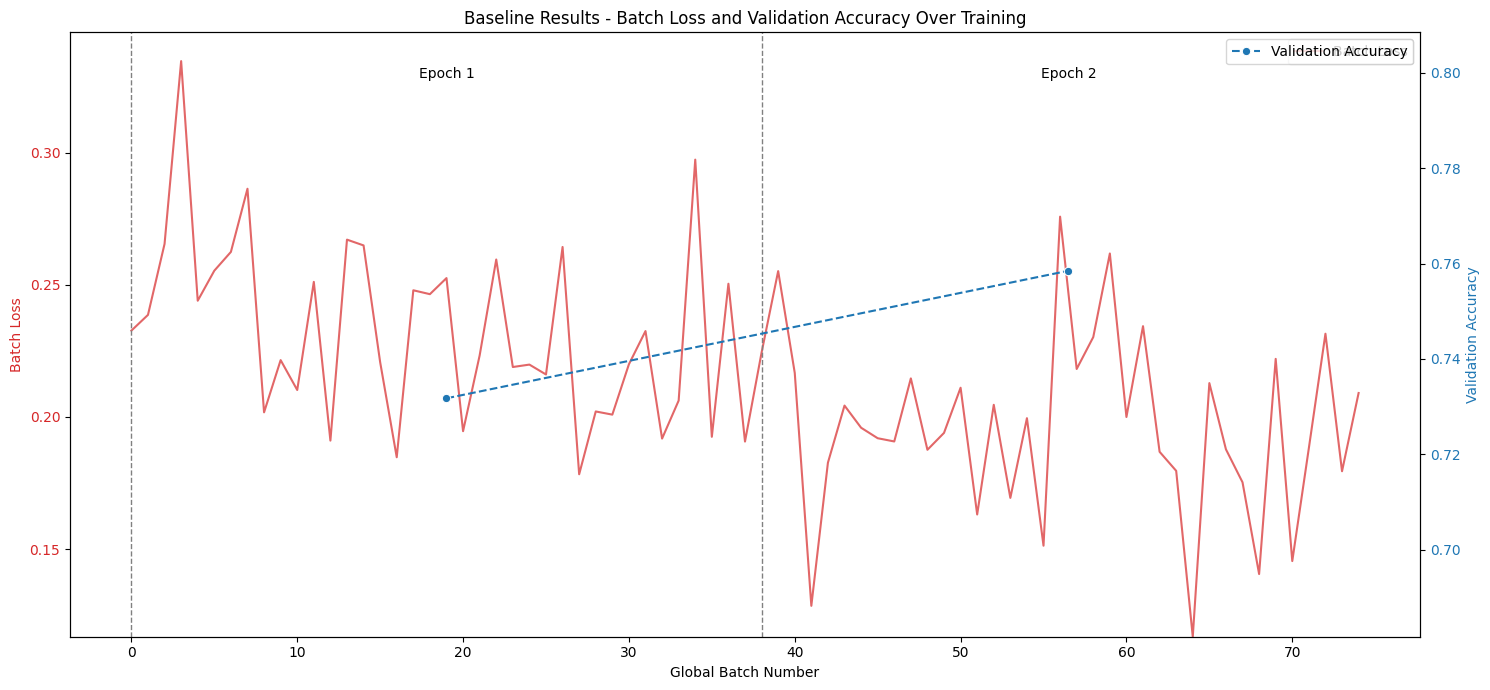

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
output_dir = "./results/baseline_results"
os.makedirs(output_dir, exist_ok=True)

batches_loss['global_batch'] = range(len(batches_loss))

# Calculate the position for epoch markers
epoch_boundaries = batches_loss.groupby('epoch')['global_batch'].min().tolist()
epoch_boundaries.append(len(batches_loss)) 

# Get the center of each epoch
epoch_centers = [(epoch_boundaries[i] + epoch_boundaries[i+1]) / 2 for i in range(len(epoch_boundaries)-1)]


# Create the plot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot batch loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Global Batch Number')
ax1.set_ylabel('Batch Loss', color=color)
sns.lineplot(data=batches_loss, x='global_batch', y='loss', ax=ax1, color=color, alpha=0.7, label='Batch Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(bottom=min(batches_loss["loss"]))

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color)
sns.lineplot(data=epoch_val_acc, x=epoch_centers, y='accuracy', ax=ax2, color=color, marker='o', linestyle='--', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(min(epoch_val_acc["accuracy"])-0.05, max(epoch_val_acc["accuracy"])+0.05)

# Add vertical lines and text for epoch boundaries
for i, boundary in enumerate(epoch_boundaries[:-1]):
    ax1.axvline(x=boundary, color='gray', linestyle='--', linewidth=1)
    # Add text label for the epoch
    ax1.text(epoch_centers[i], ax1.get_ylim()[1] * 0.95, f'Epoch {i+1}', horizontalalignment='center', color='black')

plt.title('Baseline Results - Batch Loss and Validation Accuracy Over Training')
fig.tight_layout()
plt.savefig(f"{output_dir}/loss_and_acc_model.png")
plt.show()

In [28]:
batches_loss.to_csv(f"{output_dir}/batches_loss.csv")
epoch_val_acc.to_csv(f"{output_dir}/epoch_val_acc.csv")